### LSST AGN SC Regression Example

Gordon Richards and Weixiang Yu, Drexel University, February 2020

This notebook contains example code for learning how to use the AGN training set in the SciServer environment.  See https://github.com/RichardsGroup/LSST_training.

It specifically contains example code illustrating Pandas, Matplotlib, and SciKit-Learn tools that can be used to develop intitial photo-z algorithms for AGN in the LSST context.

Where possible and appropriate, we make reference to [Jake Vanderplas' Handbook for Data Science Python]( https://jakevdp.github.io/PythonDataScienceHandbook/).

In [1]:
#Load the various packages that we'll need
import numpy as np 
import pandas as pd #to enable the use of fancy data tables
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn #SciKit-Learn machine learning package for python
import zarr #See Setup.ipynb
pd.set_option('display.max_columns', 999)
from utils import * #See Setup.ipynb

#So that plots will be displayed inline
%matplotlib inline 

In [2]:
#See what versions of the software we are running
from platform import python_version
print(python_version())
print(np.version.version)
print(pd.__version__)
print(mpl.__version__)
print(sklearn.__version__)

3.7.6
1.18.1
1.0.1
3.1.3
0.22.1


In [3]:
## If using SciServer
# See Get_started.ipynb
init()

Start by loading up the quasar database into a [Pandas DataFrames](https://jakevdp.github.io/PythonDataScienceHandbook/03.00-introduction-to-pandas.html).

In [4]:
qso_df = get_qso_cat()
qso_df.head(5)

,train_id,ra_sdss,dec_sdss,sdssj,z,z_err,thing_id,specobjid,spec,objid,psfmag_u,psfmag_g,psfmag_r,psfmag_i,psfmag_z,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,spec2coadd,ra_sp,dec_sp,SPIES_ID,FLUX_AUTO_ch1,FLUXERR_AUTO_ch1,FLUX_AUTO_ch2,FLUXERR_AUTO_ch2,CLASS_STAR_ch1,CLASS_STAR_ch2,sdss2spies,sdss2gaia,gaia_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,lcN,psPm[0],psPm[1],psParallax,dered_u,dered_g,dered_r,dered_i,dered_z,stdColor[0],stdColor[1],stdColor[2],stdColor[3],psFlux[u],psFlux[g],psFlux[r],psFlux[i],psFlux[z]
0,0,310.0377,-1.005592,204009.04-010020.1,2.167268,0.000676,<NA>,276352159556042752,7,8647475119809364088,19.64425,19.11970,18.69050,18.39786,18.12030,0.008446,0.003265,0.003569,0.002969,0.005960,0.332155,0.244396,0.177257,0.134408,0.095297,0.083856,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.024083,4226318531605913088,0.225240,0.283972,-0.609215,0.464463,-0.206735,0.305267,60,-0.609215,-0.206735,0.225240,19.312095,18.875304,18.513243,18.263452,18.025003,0.436791,0.362060,0.249792,0.238449,65942.328054,68419.255122,142798.907734,179737.984132,228014.565848
1,3,311.6088,0.393812,204626.10+002337.7,0.333015,0.000351,<NA>,537282917827608576,7,8647475121420632840,19.98406,18.87617,17.98685,17.88391,17.11791,0.011383,0.001996,0.001869,0.002298,0.003088,0.494767,0.364045,0.264036,0.200210,0.141952,0.051798,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.092993,4228017414511443968,-0.149525,0.160723,0.044235,0.275073,0.075344,0.179892,69,0.044235,0.075344,-0.149525,19.489293,18.512125,17.722814,17.683700,16.975958,0.977168,0.789311,0.039115,0.707741,56011.332155,58115.957521,295732.889174,306580.434350,599285.639829
2,4,312.3636,0.718380,204927.25+004306.1,1.699121,0.000973,<NA>,314071864353751040,7,8647475121957832451,21.65874,20.98272,20.43363,19.93146,19.81973,0.037532,0.009041,0.007869,0.007637,0.022191,0.526905,0.387692,0.281186,0.213215,0.151172,0.154056,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218568,4228378535360381440,-0.486411,0.729782,-0.776679,2.051325,0.635052,1.033818,54,-0.776679,0.635052,-0.486411,21.131835,20.595028,20.152444,19.718245,19.668558,0.536807,0.442585,0.434199,0.049687,12319.895839,12794.084912,31547.575429,47059.204593,50039.124902
3,5,312.4020,0.834625,204936.47+005004.6,0.475306,0.000354,<NA>,314071864311808000,7,8647475121957831705,20.92427,20.42534,20.16220,19.86281,19.65058,0.020328,0.005620,0.006083,0.007393,0.019640,0.520510,0.382986,0.277773,0.210627,0.149337,0.160105,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,118,NaN,NaN,NaN,20.403761,20.042354,19.884427,19.652183,19.501243,0.361406,0.157927,0.232244,0.150940,24118.091101,25029.261444,40383.598908,50012.543099,58422.366330
4,6,312.4340,0.455123,204944.16+002718.4,2.080289,0.001066,<NA>,314353417491316736,7,8647474692461166737,20.41388,20.34367,20.21098,19.94661,19.67556,0.013942,0.005312,0.006064,0.007587,0.019144,0.459490,0.338089,0.245210,0.185935,0.131831,0.150507,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100156,4228358022596118528,0.250211,0.772921,1.965712,2.234255,-0.107082,1.024258,54,1.965712,-0.107082,0.250211,19.954390,20.005581,19.965770,19.760675,19.543730,-0.051192,0.039811,0.205095,0.216945,36491.532269,37865.005535,37467.915153,45254.921252,56170.337863


What columns are available to us?

In [5]:
qso_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24579 entries, 0 to 24578
Data columns (total 62 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   train_id          24579 non-null  Int64  
 1   ra_sdss           24579 non-null  float64
 2   dec_sdss          24579 non-null  float64
 3   sdssj             24579 non-null  object 
 4   z                 24579 non-null  float64
 5   z_err             24579 non-null  float64
 6   thing_id          17488 non-null  Int64  
 7   specobjid         24579 non-null  Int64  
 8   spec              24579 non-null  int64  
 9   objid             24579 non-null  Int64  
 10  psfmag_u          24579 non-null  float64
 11  psfmag_g          24579 non-null  float64
 12  psfmag_r          24579 non-null  float64
 13  psfmag_i          24579 non-null  float64
 14  psfmag_z          24579 non-null  float64
 15  psfmagerr_u       24579 non-null  float64
 16  psfmagerr_g       24579 non-null  float6

For now, let's just use the colors as indicated in the following cell.

In [6]:
collist = ['ra_sdss','dec_sdss','stdColor[0]','stdColor[1]','stdColor[2]','stdColor[3]','z']
train_df = qso_df[collist]

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24579 entries, 0 to 24578
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ra_sdss      24579 non-null  float64
 1   dec_sdss     24579 non-null  float64
 2   stdColor[0]  24579 non-null  float64
 3   stdColor[1]  24579 non-null  float64
 4   stdColor[2]  24579 non-null  float64
 5   stdColor[3]  24579 non-null  float64
 6   z            24579 non-null  float64
dtypes: float64(7)
memory usage: 1.3 MB


SciKit-Learn uses a convention where "X" is a multi-dimensional matrix of features (columns) for each object (rows).  In the case of regression "y" are the "answers", which here means the redshift.

We'll next build both "y" and "X" (the order is important) from our training dataframe.  

"y" is just the values of redshift.

Once the label array, y, is defined, we drop that information from the dataframe (otherwise, we'd be cheating!) and define "X".  Let's also drop RA and Dec.

In [8]:
y = train_df['z'].values
y

array([2.167268, 0.333015, 1.699121, ..., 2.609345, 2.097516, 0.2843  ])

In [9]:
X = train_df.drop(['ra_sdss','dec_sdss','z'],axis=1).values
X
print(X.shape)

(24579, 4)


Let's take a look at the data.

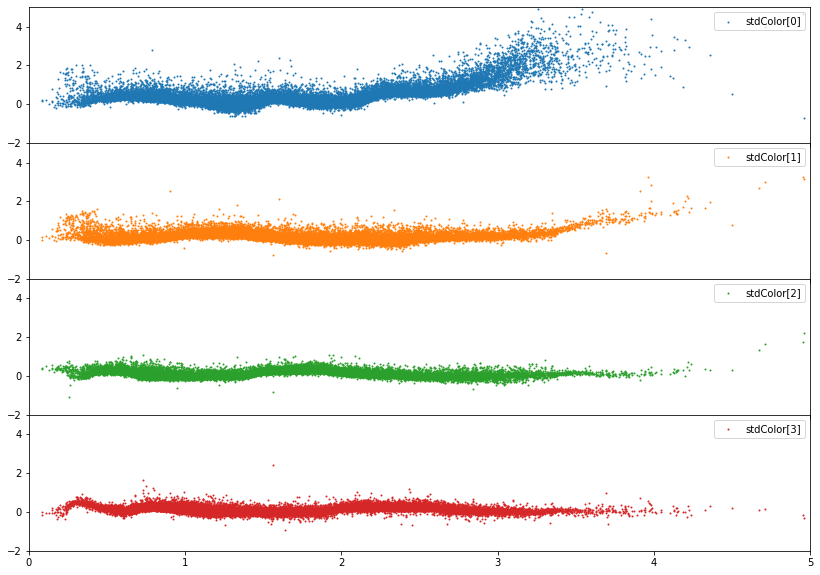

In [10]:
fig, axarr = plt.subplots(4, sharex='col',gridspec_kw={'hspace':0, 'wspace':0},figsize=(14,10))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i,ax in enumerate(axarr):
    ax.scatter(y,X[:,i], s=1, color=cycle[i], label=train_df.columns[i+2])
    ax.legend(loc='upper right')
    ax.set_ylim([-2,5])
    ax.set_xlim([0,5])

We are going to try to use the fact that the "shape" of this distribution with redshift is different for each color to predict the redshift of new objects that lack spectroscopy.

In the classification example, the Random Forest worked pretty well, so let's try the [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

In [11]:
from sklearn.ensemble import RandomForestRegressor

In [12]:
model = RandomForestRegressor(n_estimators=100,random_state=42)

In [13]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(model, X, y, cv=5)

Let's plot the known redshift vs. the predicted redshift to see how we did.

Text(0, 0.5, 'Photo-z')

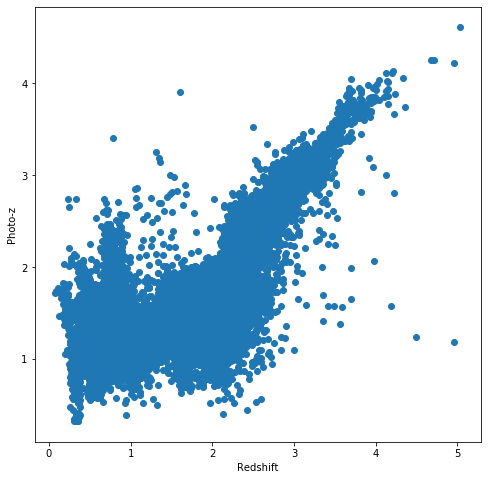

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y,y_pred)
ax.set_xlabel('Redshift')
ax.set_ylabel('Photo-z')

This looks terrible!  But it really is not as bad as it seems (as we can see by making a better plot).

In [15]:
#Put the known redshift and predicted redshift into a new Pandas dataframe.
df = pd.DataFrame({'Redshift':y,'Photo-z':y_pred})

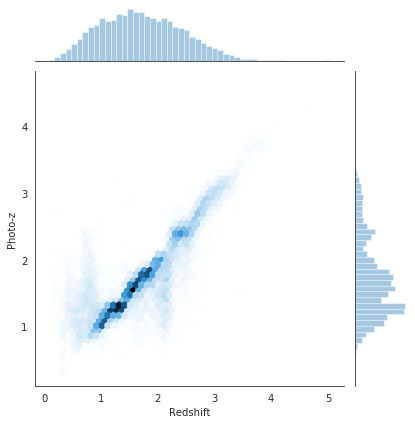

In [16]:
#Make a fancy plot
import seaborn as sea
with sea.axes_style('white'):
    sea.jointplot('Redshift','Photo-z',df, kind='hex')

While we can certainly do a lot better, most of the objects have their redshifts well predicted, which is also illustrated by the following histogram.

Text(0.5, 0, 'z_{spec} - z_{phot}')

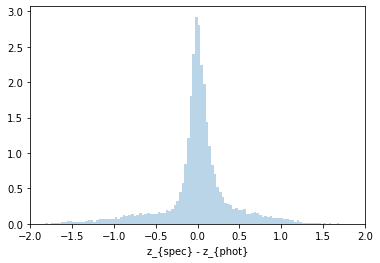

In [17]:
#Plot a histogram of the results
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=200)
plt.hist(y-y_pred, **kwargs);
plt.xlim(-2,2)
plt.xlabel('z_{spec} - z_{phot}')

We might like to know which features contributed the most to the accuracy.  This will be especially true when we start including novel features like DCR.

In this case that information is stored in the `feature_importances_`.

In [18]:
model.fit(X,y)
model.feature_importances_

array([0.50910054, 0.1669379 , 0.21094059, 0.11302097])

We see that $u-g$ contributes the most (by far), followed by $r-i$, then $g-r$, and finally $i-z$.

Ultimately our algorithm (likely multiple algorithms) will need to produce full PDFs and ideally will handle both the LLAGN and luminous quasars.